# Восстановление золота из руды

## Описание проекта

Подготовить прототип модели машинного обучения для компании «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В данных приведены параметры добычи и очистки.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Описание данных

1. Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- - Xanthate **— ксантогенат (промотер, или активатор флотации);
- - Sulphate — сульфат (на данном производстве сульфид натрия);
- - Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота
2. Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

## Подготовка данных

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>")) # растягиваем тетрадку на весь экран, для более комфортной работы

In [2]:
from random import randint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

from nona.nona import nona

import warnings

Подключаем все необходимые библиотеки

In [3]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore', message='divide by zero encountered in double_scalars')

Отключаем предупреждения от pandas

In [4]:
def recovery(C, F, T):
    return ((C * (F - T)) / (F * (C - T))) * 100

Создаем функцию для расчета `revovery` (эффективность обогащения).

In [5]:
def sMAPE(target, prediction):
    return float((1/len(target)) * np.sum(2 * np.abs(prediction - target) / (np.abs(target) + np.abs(prediction))) * 100)


Создаем функцию для расчета `sMAPE` (симметричное среднее абсолютное процентное отклонение).

In [6]:
def final_sMAPE(sMAPE_rougher, sMAPE_final):
    return 0.25 * sMAPE_rougher + 0.75 * sMAPE_final

Создаем функцию для расчета `final_sMAPE` (финальное симметричное среднее абсолютное процентное отклонение). По черновому и финальному материалу.

In [7]:
def show_info(df):
    display(df.describe())
    df.info()
    df.hist(figsize=(45, 30), bins=20)

Создаем функцию `show_info` для отображения основной информации о data frame, который подается на вход функции.

In [8]:
try:
    df_full = pd.read_csv('gold_recovery_full_new.csv')
    df_train = pd.read_csv('gold_recovery_train_new.csv')
    df_test = pd.read_csv('gold_recovery_test_new.csv')
except:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

Записываем значения csv файлов в pandas Data frame и присваиваем им соответсвующее переменные.

In [9]:
df_full.head(3)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


Выводим первый три строки общей таблицы на экран, чтобы убедится в корректности парсинга данных.

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


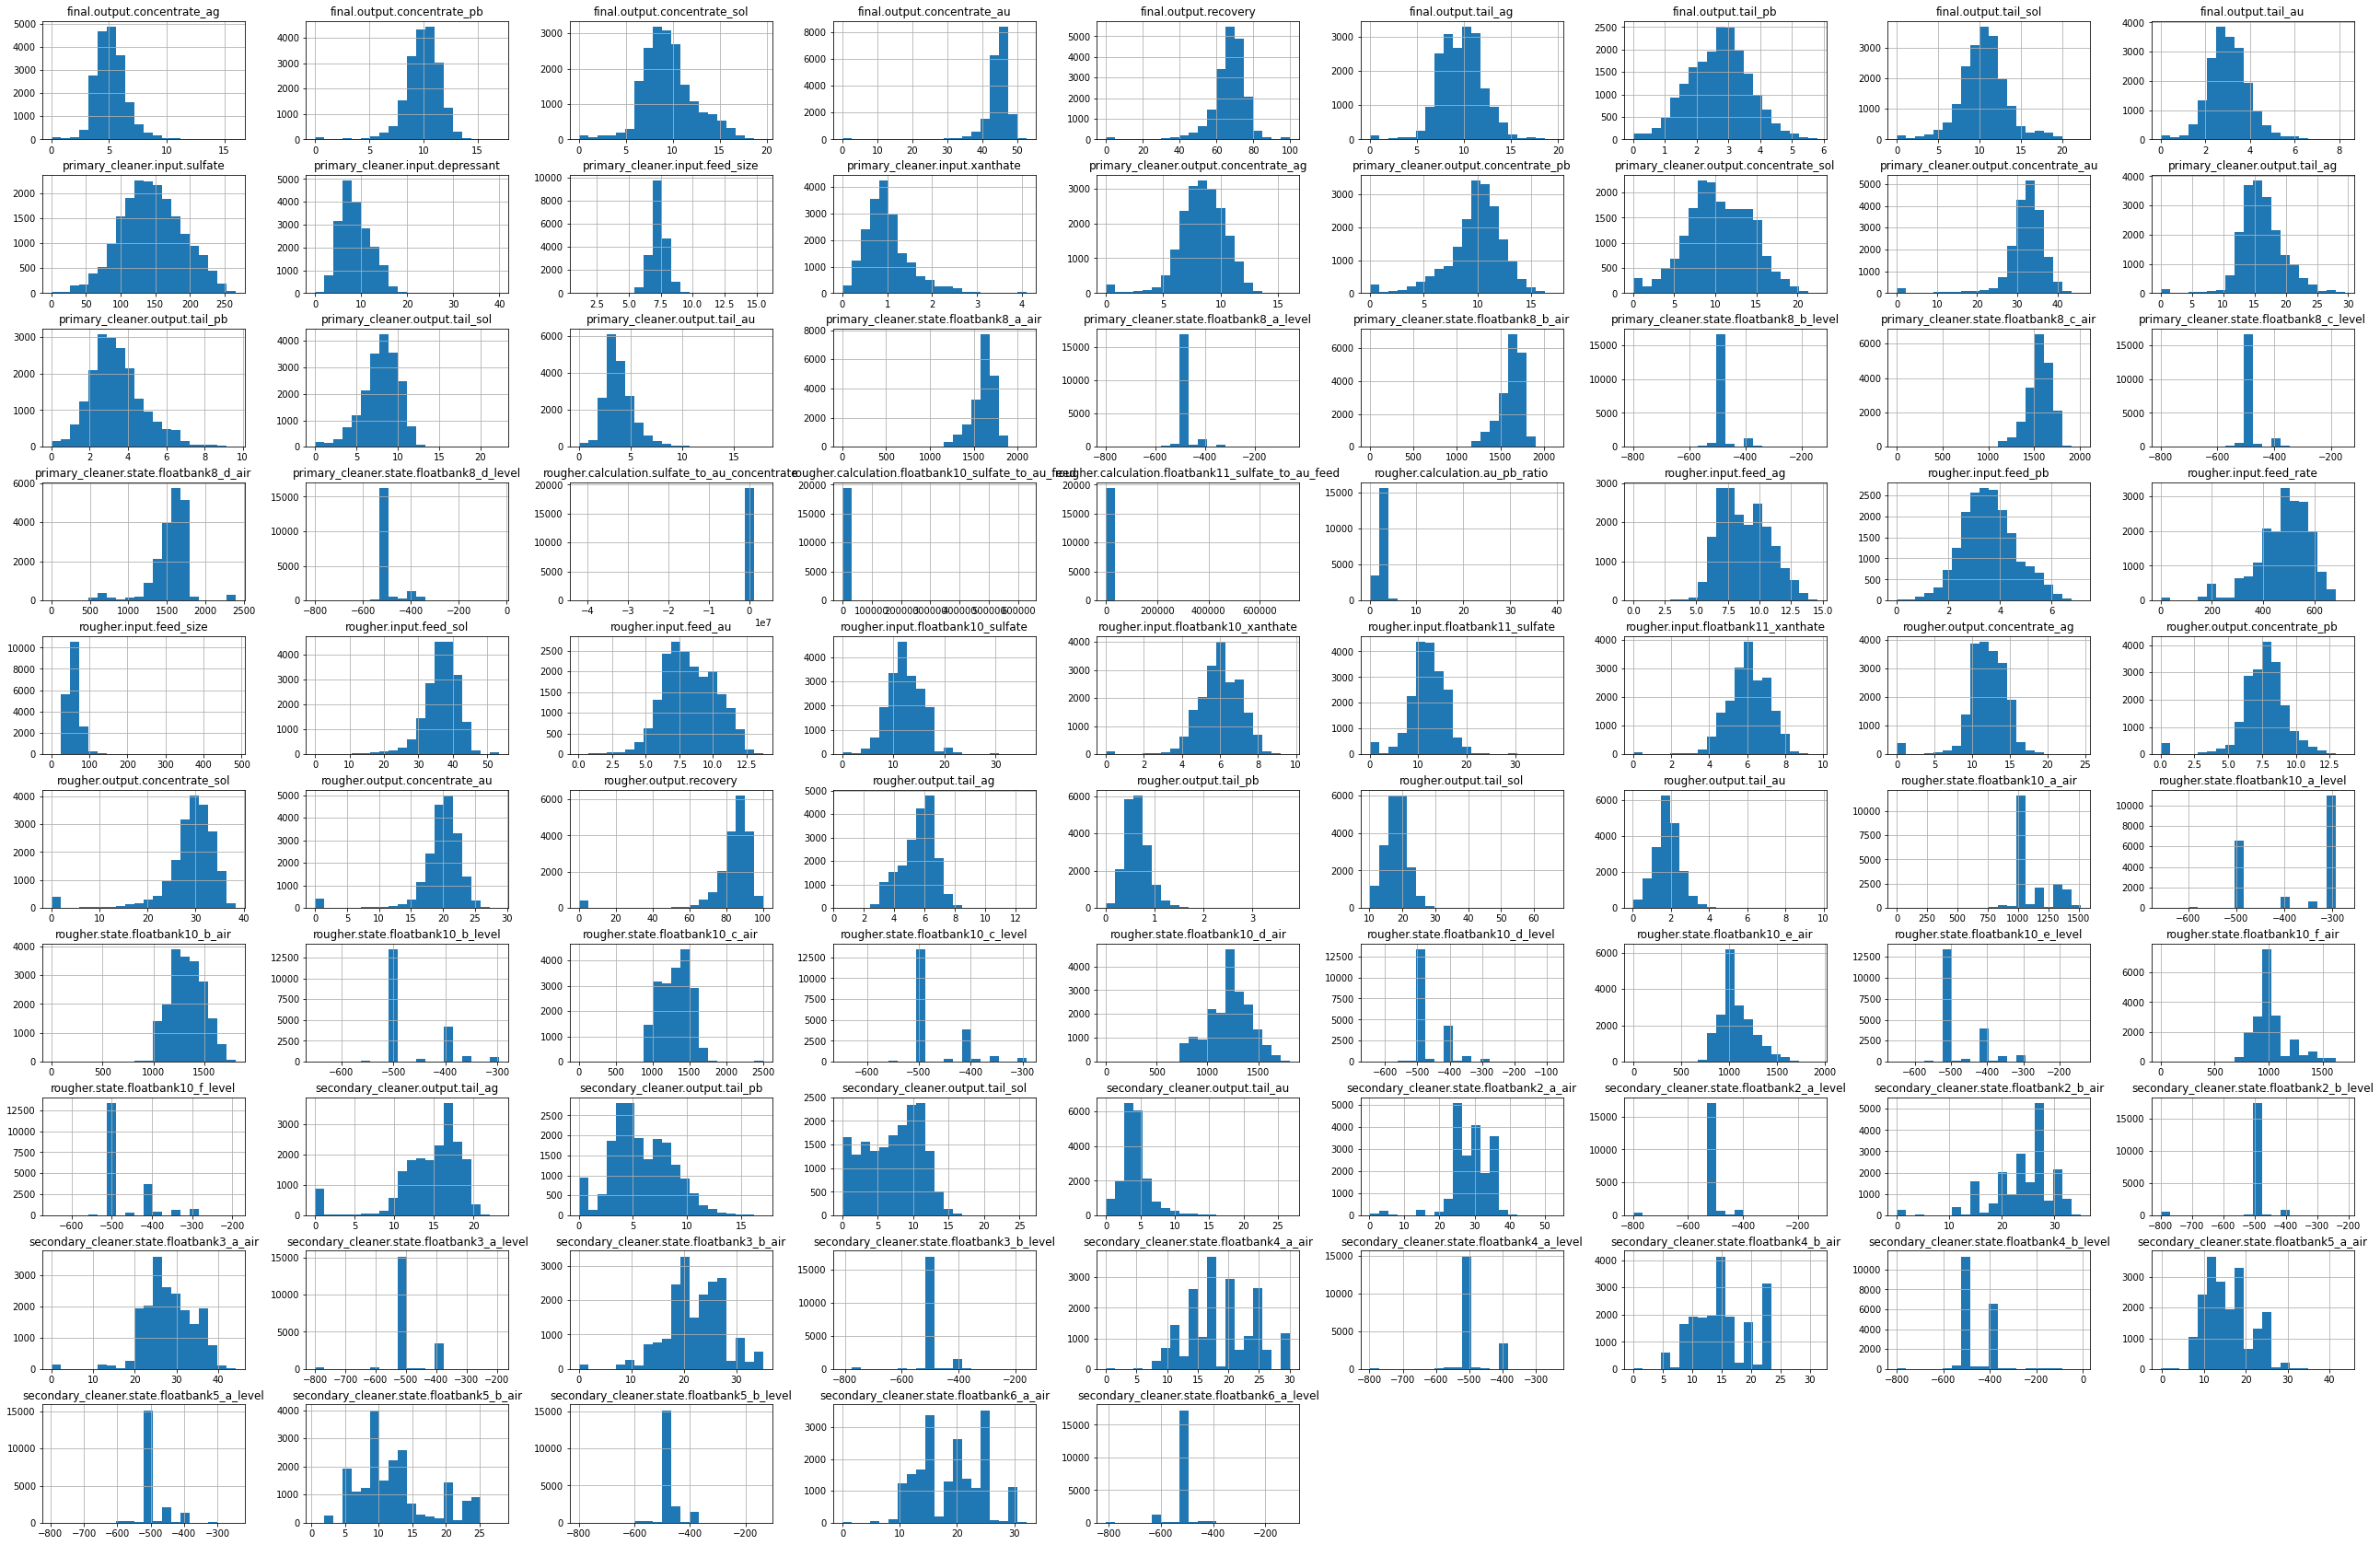

In [10]:
show_info(df_full)

Вывод сверху дает нам представление о данных (`gold_recovery_full_new.csv`), с которыми мы работаем.
- присутствуют данные двух типов float и object
- значения положительные и отрицательные
- у большинства столбцов распределение приближенно к нормальному, кроме некоторых колонок .sate.
- в данных есть не большое кол-во пропусков

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


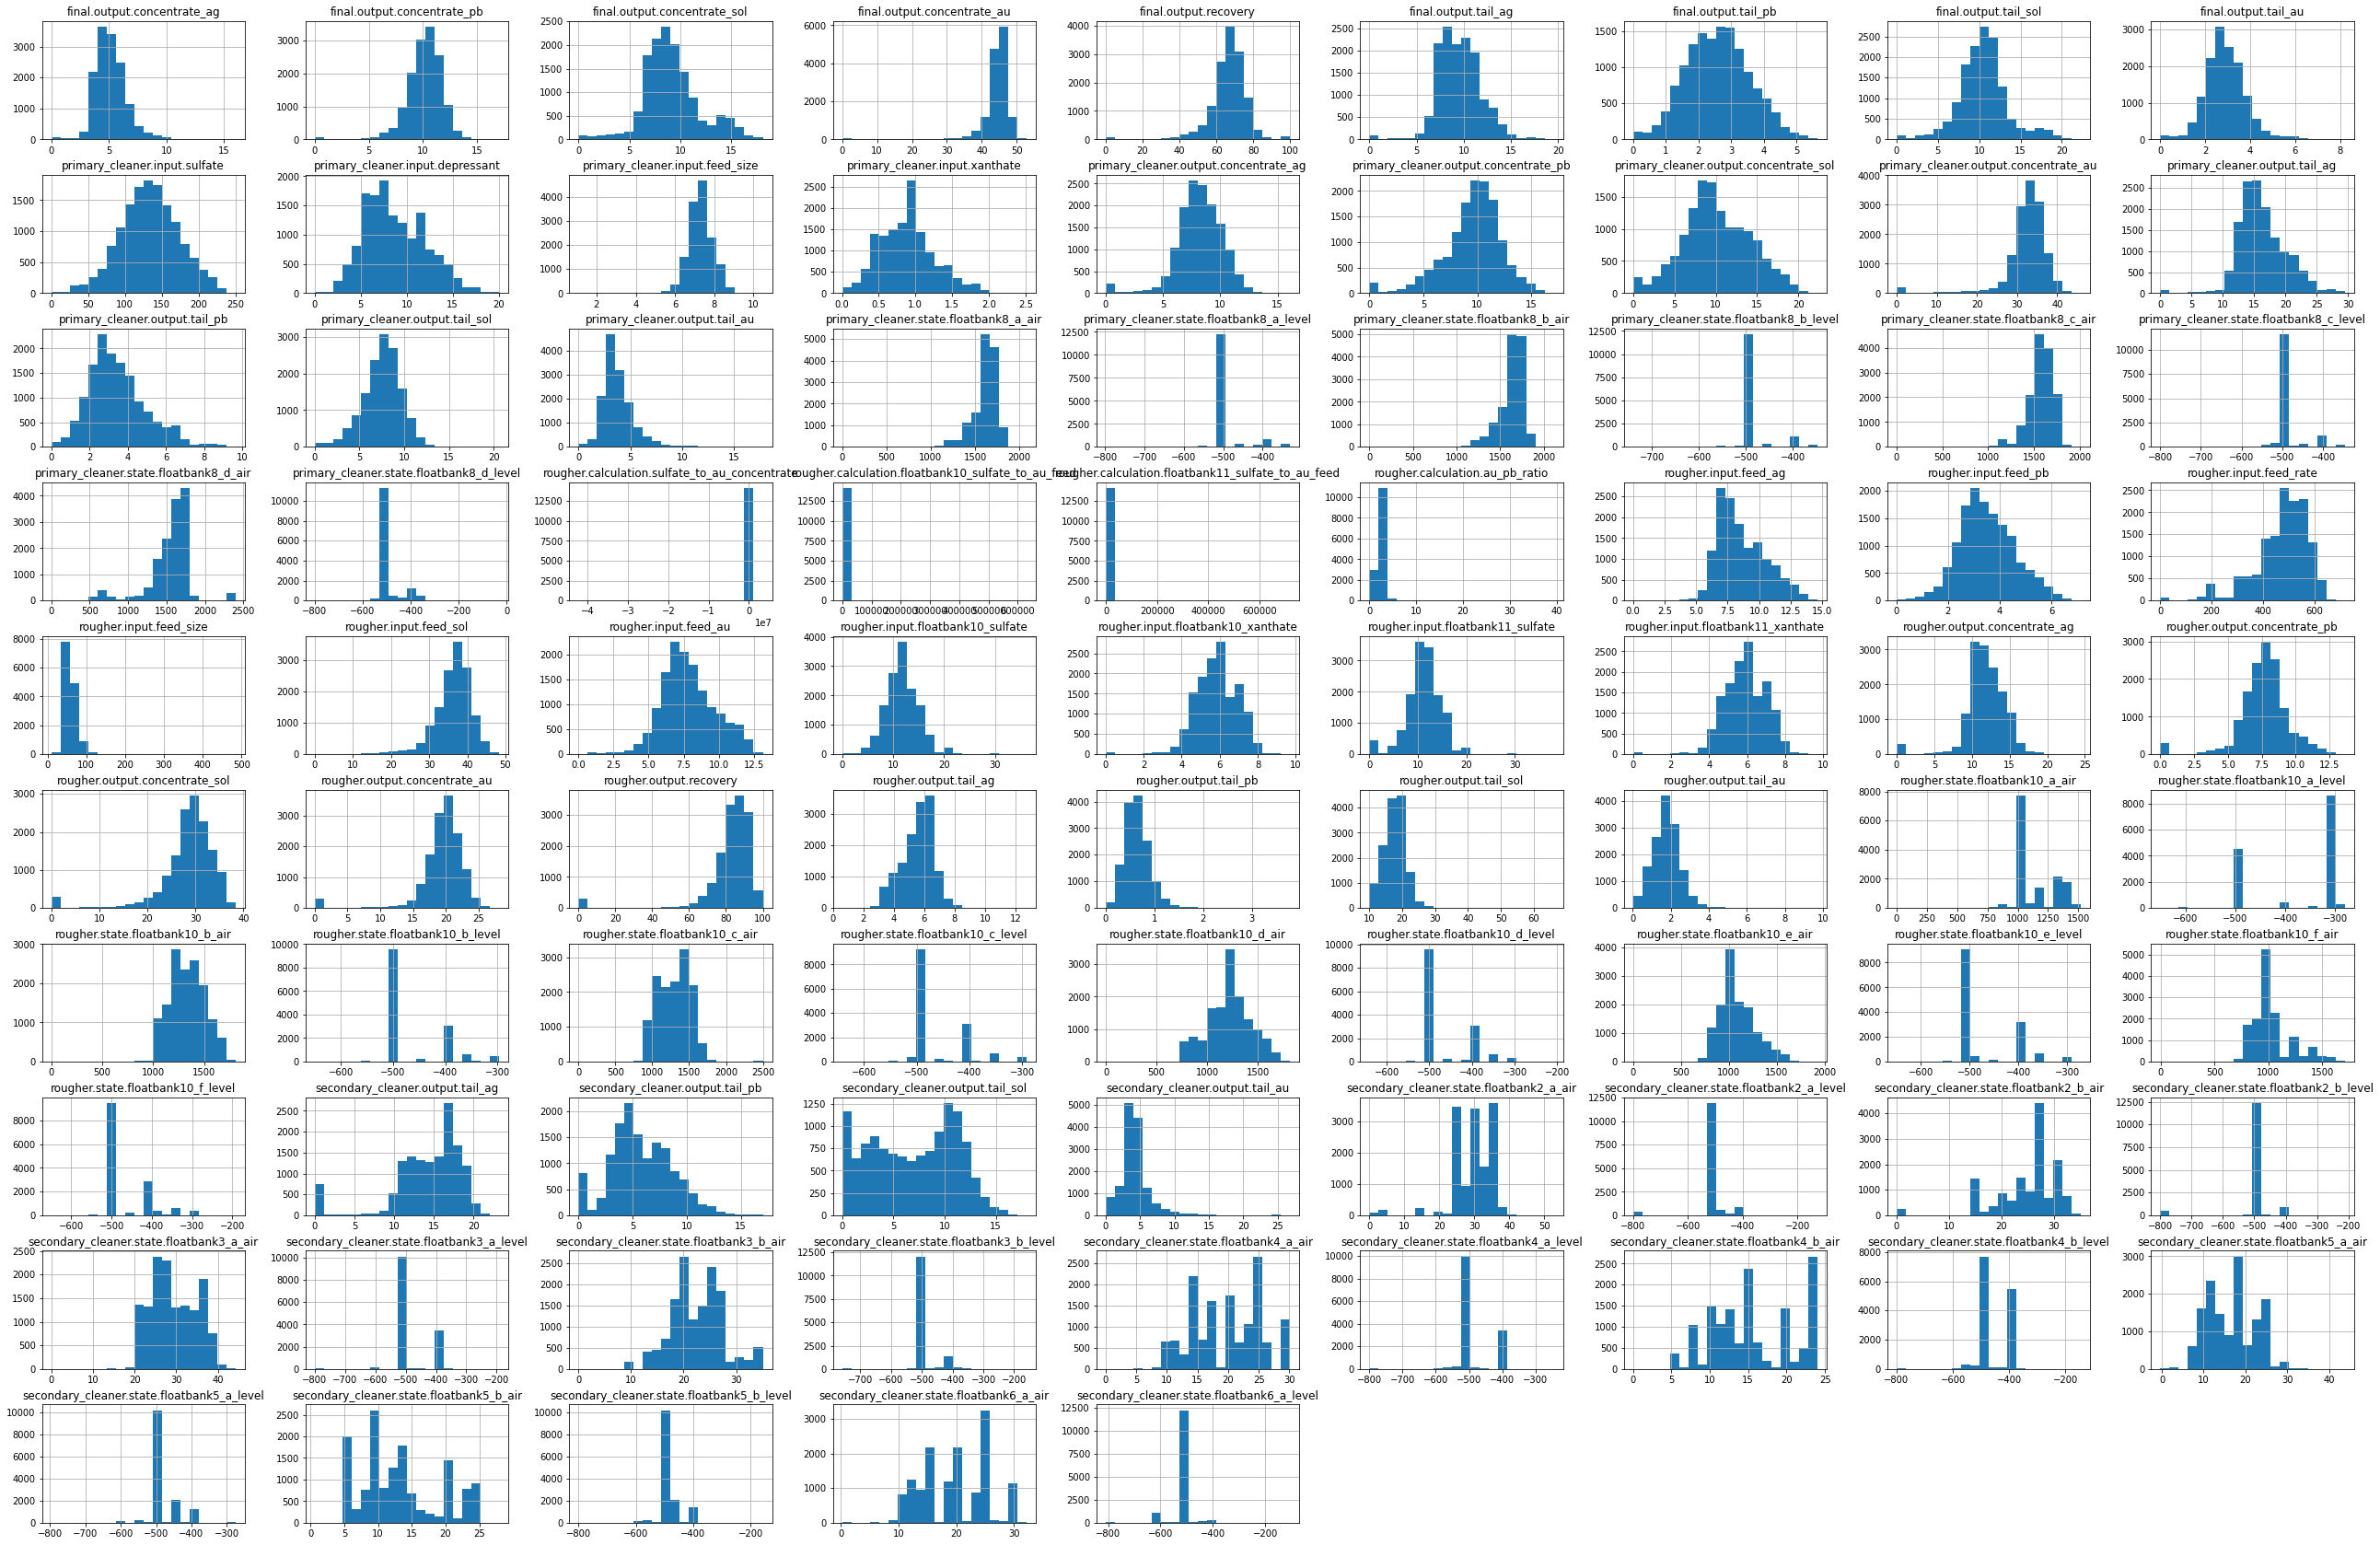

In [11]:
show_info(df_train)

Основные выводы по тренированному дата сету (`gold_recovery_train_new.csv`):
- данные совпадают по свой природе и распределению с общей выборкой(`gold_recovery_full_new.csv`)
- тренировочный дата сет - это примерно 70% от общей выборки
- как и в общей выборки в эту перешли пропуски

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

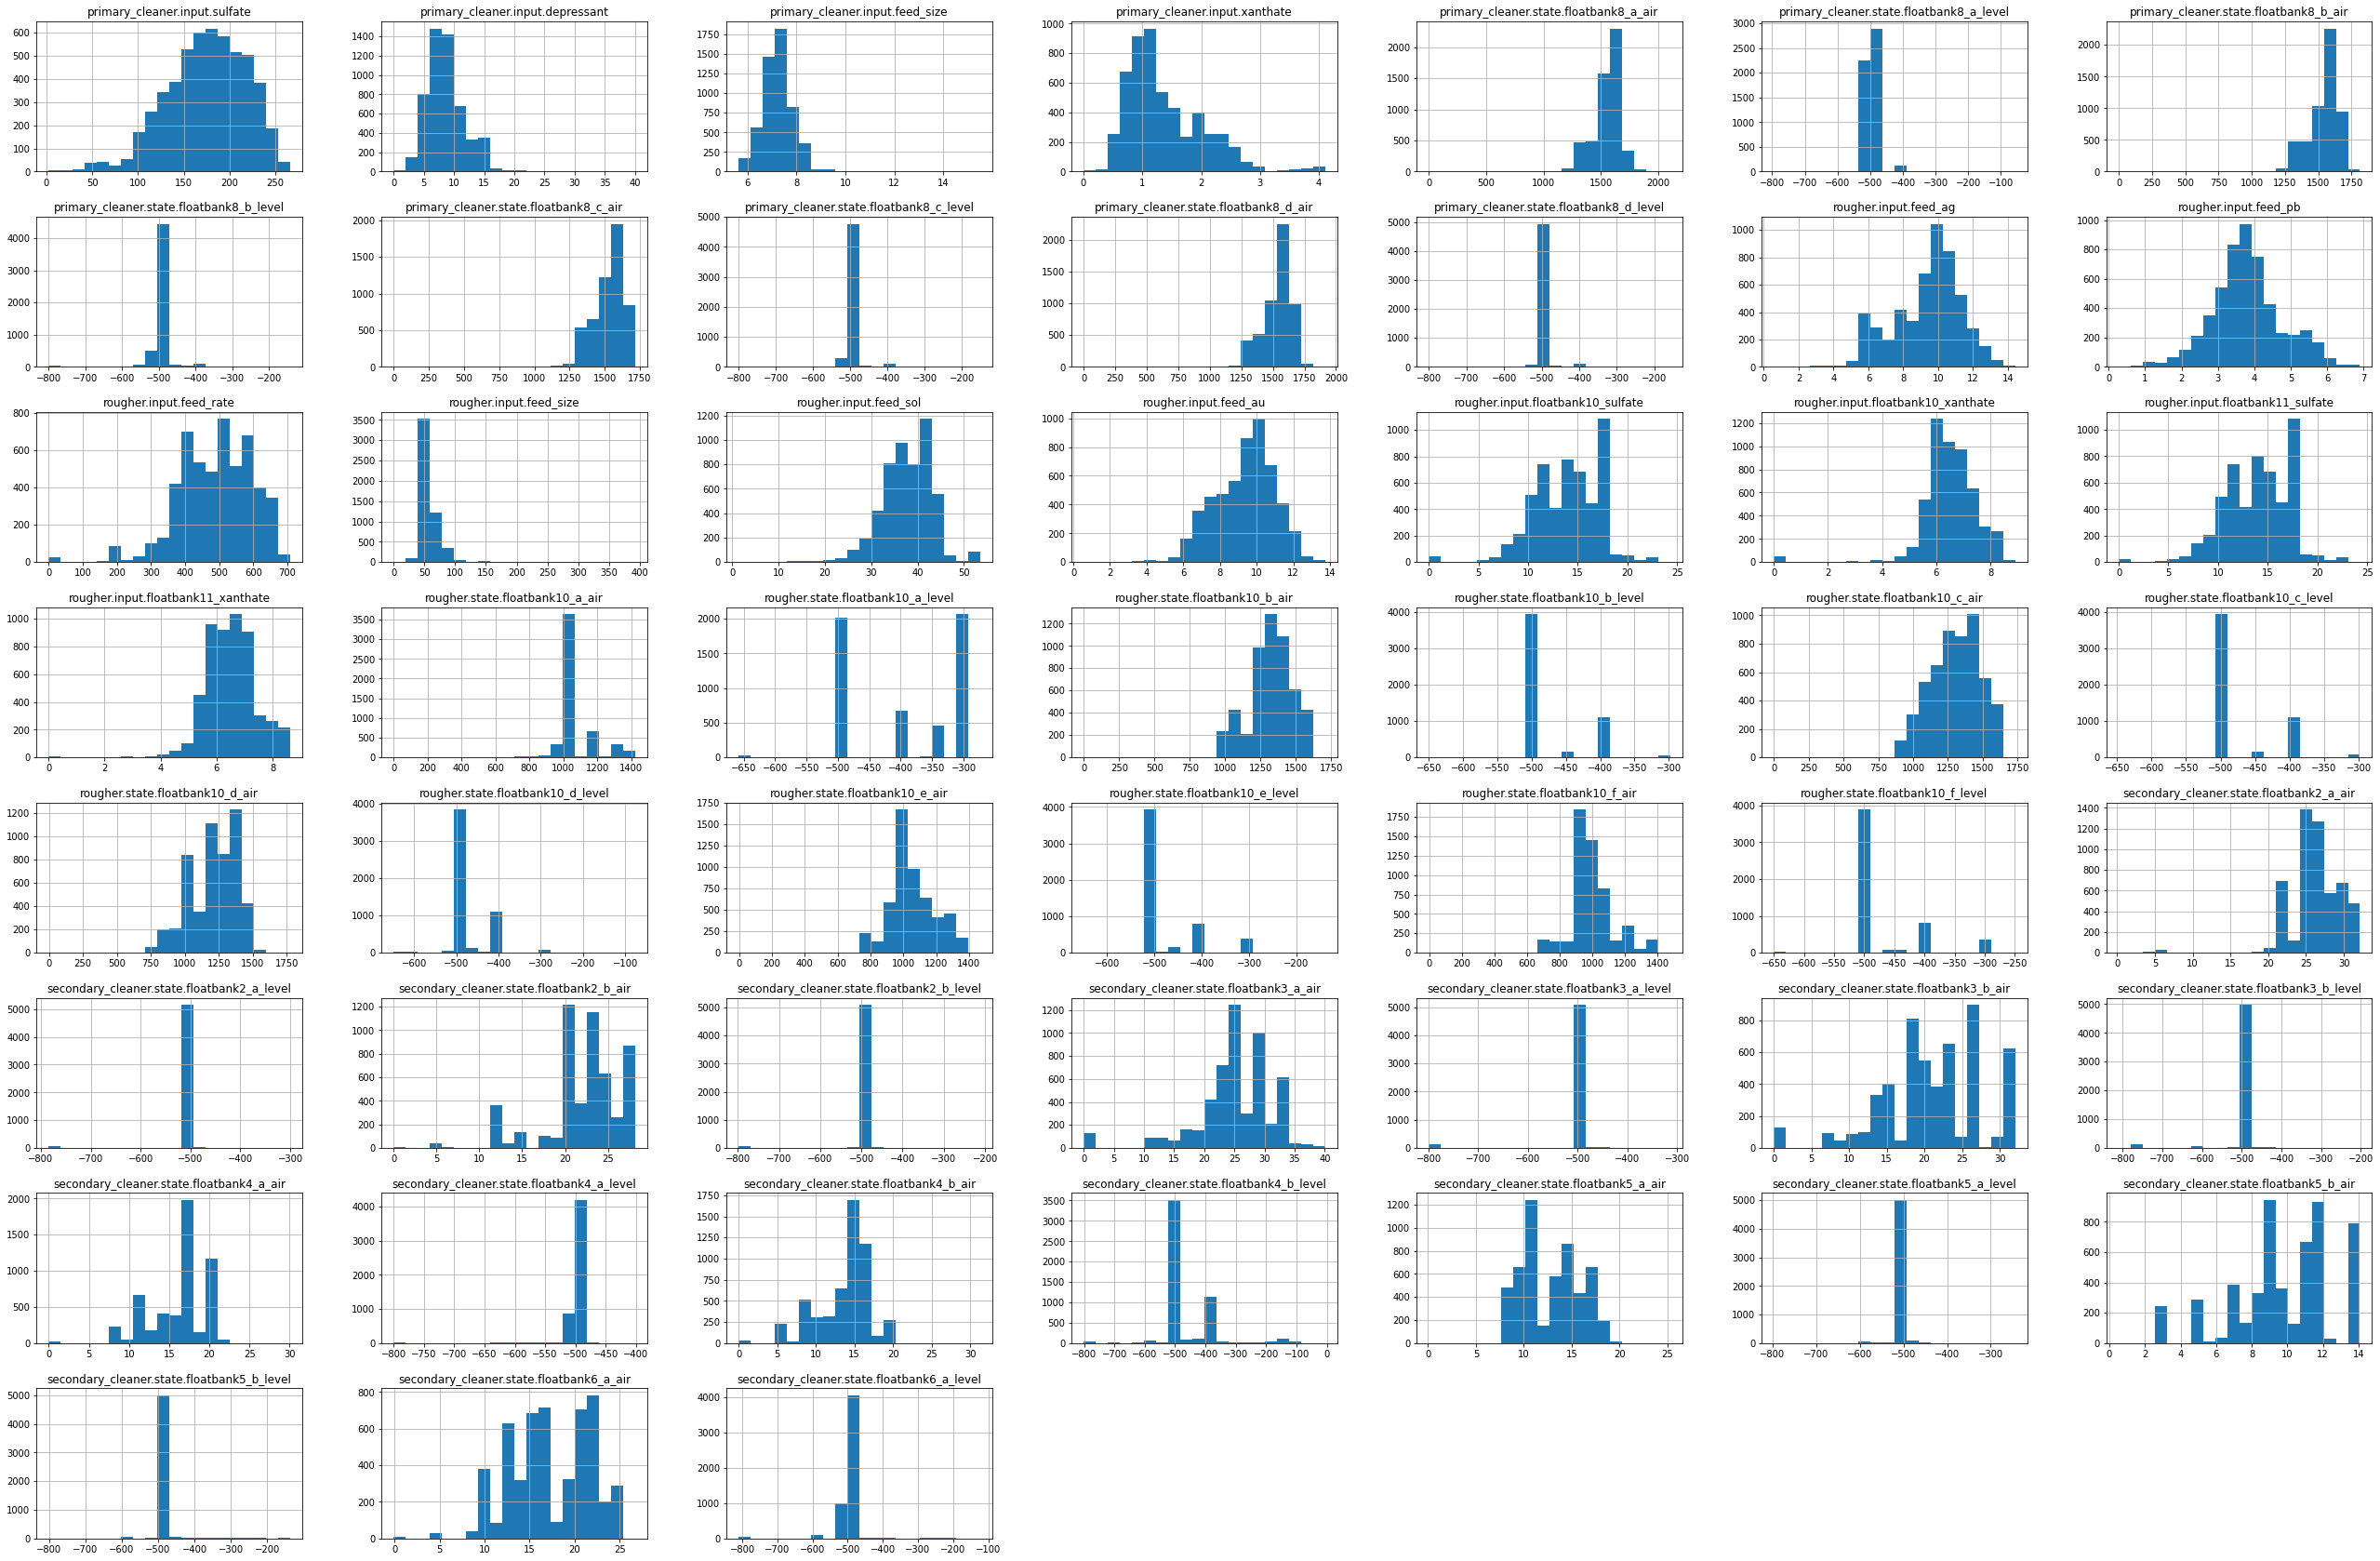

In [12]:
show_info(df_test)

Основные выводы по тестовому дата сету (`gold_recovery_test_new.csv`):
- данные совпадают по свой природе и распределению с общей выборкой(`gold_recovery_full_new.csv`)
- тестовый дата сет - это примерно 30% от общей выборки
- как и в общей выборки в эту перешли пропуски

In [13]:
df_train = df_train.drop('date', axis=1)

Удаляем колонку `date` в обучающей выборке. В нашем случаем, столбец `date` выступает в роле ID. Поэтому, на результат он не повлияет и его можно смело удалять.

In [14]:
nona(df_train)

100%|██████████| 86/86 [00:15<00:00,  5.50it/s]


Избавляемся от пропусков в обучающей выборке, с помощью библиотеки `nona`.

In [15]:
recovery_df = recovery(C=df_train['final.output.concentrate_au'], F=df_train['rougher.input.feed_au'], T=df_train['final.output.tail_au'])
MAE_recovery = mean_absolute_error(recovery_df, df_train['final.output.recovery'])
print(f'MAE for calculation and real data: {MAE_recovery}')

MAE for calculation and real data: 8.538049763979541e-15


Чтобы убедится в корректности расчет, проведем их самостоятельно и сравним с расчетами из таблицы. Метрика MAE показала минимальное различие (13 нулей после запятой). Расчеты для столбца `recovery` проведены корректно.

In [16]:
df_train.drop(columns=df_test.drop('date', axis=1).columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14149 non-null  float64
 1   final.output.concentrate_pb                         14149 non-null  float64
 2   final.output.concentrate_sol                        14149 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14149 non-null  float64
 7   final.output.tail_sol                               14149 non-null  float64
 8   final.output.tail_au                                14149 non-null  float64


Выше сделан вывод столбцов, которые не вошли в тестовый дата сет. В нем мы можем наблюдать только колонки c выходными (output) и расчетными (calculation) характеристиками.
Эти данные мы получаем в процессе обработки золотосодержащего сырья. Поэтому, использовать их в обучение будет не корректно. Если включить их в обучающие признаки, произойдет утечка целевого признака `final.output.recovery` и `rougher.output.recovery`.

In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

В тестовой выборке мы наблюдаем только исходный (`input`) параметры сырья, параметры используемые при его обработки (`state`), дата и время обработки.

Для обучения модели нужно использовать признаки из тестовой выборки (`df_test`). В противном случае нельзя гарантировать что не произойдет утечки данных в целевой признак. К тому же, заказчик будет использовать именно эти данные для тестирования и использования модели. Но нужно проверить данные на мультиколлинеарность и провести предобработку, перед обучением модели. Очень вероятно, что нужно будет исключить еще несколько столбцов.

In [18]:
metals = ['au', 'ag', 'pb']
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'primary_cleaner.output.concentrate', 'final.output.concentrate']

drop_list = []
for stage in stages:
    for prefix in metals:
        drop_list.append(f'{stage}_{prefix}')

df_train.drop(df_train.loc[(df_train[drop_list] < 0.5).any(axis=1)].index, inplace=True)
df_test.drop(df_test.loc[(df_test[drop_list[:3]] < 0.5).any(axis=1)].index, inplace=True)

На гистограммах можно наблюдать, что в колонках с концентраций метала, присутствуют нулевые значения. Такие значения получить очень маловероятно. Скорее всего, случился сбой в считывание данных. Дополнительное подтверждение находится в блоке `Анализ`. Поэтому, удаляем колонки с аномально низкими значениями.

In [19]:
features = df_train.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1)
target_rougher = df_train['rougher.output.recovery']
target_final = df_train['final.output.recovery']

Записываем в переменную `features` все признаки, кроме целевых `final.output.recovery` и `rougher.output.recovery`. Их мы записываем в переменные `target_rougher` и `target_final`, соответственно.

In [20]:
features = features[df_test.drop('date', axis=1).columns]

Оставляем в выборке `features` только признаки, которые есть в тестовой выборке `df_test`.

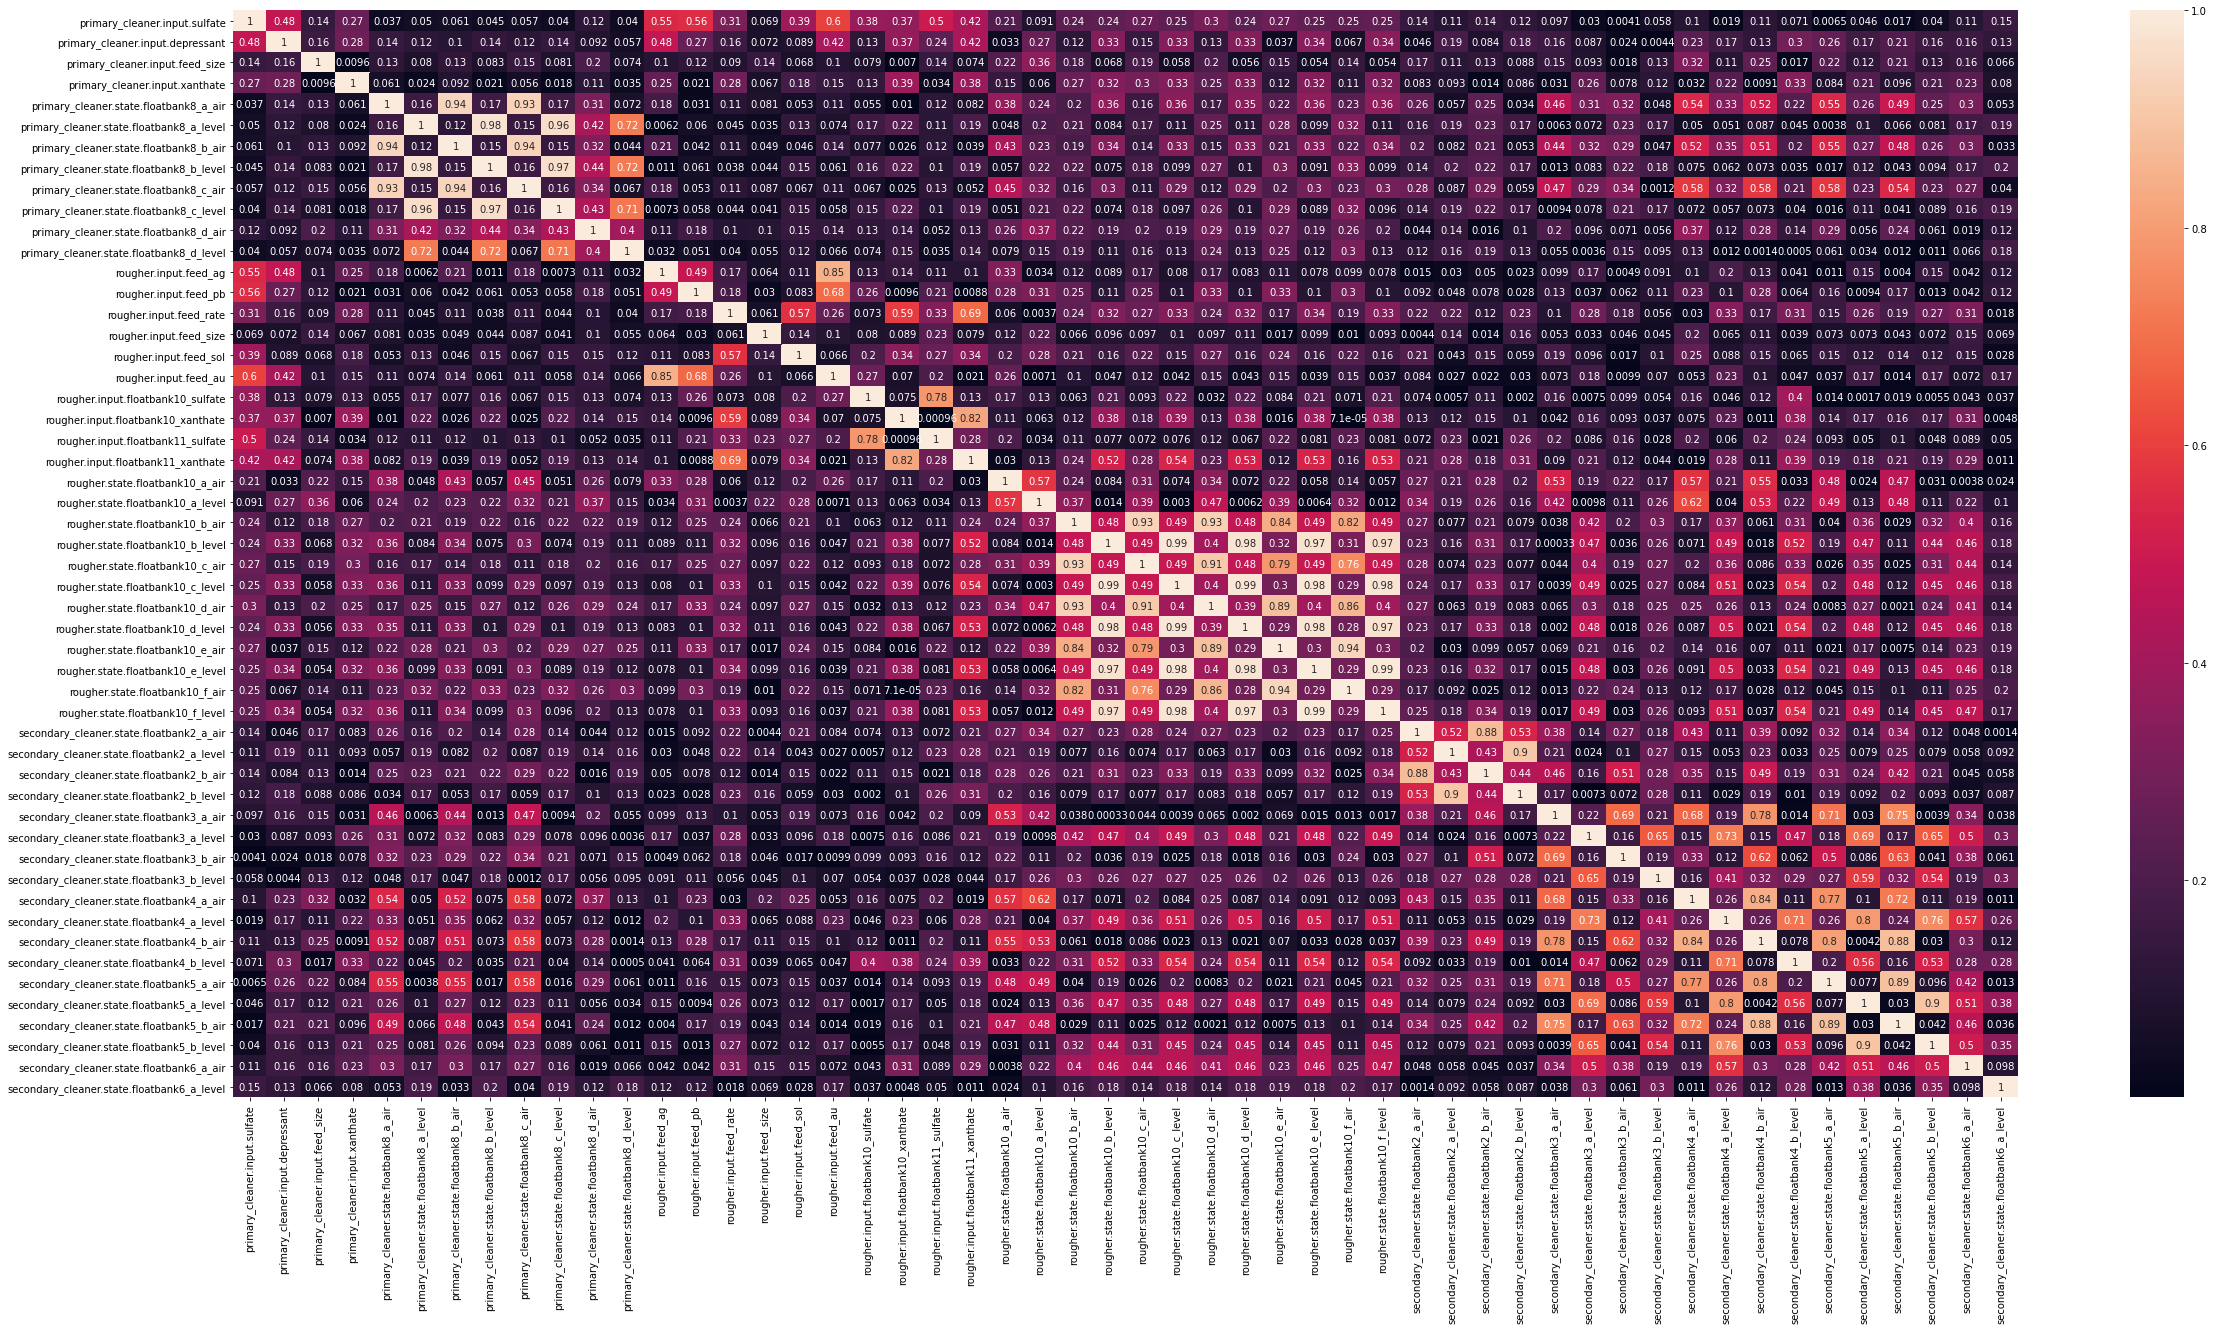

In [21]:
# Calculate correlation matrix
corr_matrix = features.corr().abs()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(40, 20))
sns.heatmap(corr_matrix, annot=True)
plt.show();

Выводим тепловую карту матрицы корреляций. Можем наблюдать, что много признаков имеют сильную корреляцию между собой (в каких-то случаях почти равна 100%). Это объясняется тем, что state напрямую рассчитывается/считывается из текущего показателя обработки. Эти признаки очень негативно повлияют на результаты модели (особенно линейной).

In [22]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
features = features.drop(features[to_drop], axis=1)

/tmp/ipykernel_111/944694804.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


Удаляем столбцы, где корреляция больше 90% (0.90).

In [23]:
# X = add_constant(features)
# multi_cor_columns = pd.Series([VIF(X.values, i)
#                         for i in range(X.shape[1])],
#                         index=X.columns).drop('const',axis=0)
#
# multi_cor_columns

In [24]:
# features = features[(multi_cor_columns[multi_cor_columns <= 10]).index]

После удаления явной корреляции, проведем тест на мультиколлинеарность, используя функцию `VIF` из библиотеки `statsmodels`. Еще остались столбцы с высокой корреляцией. Все колонки, где значение превышает 10, стоит удалить.
В данном случае, решено было это не делать, так как, модель случайного леса показывает результат хуже, если удалить эти столбцы.

In [25]:
# random_seed = randint(1, 9999999)
random_seed = 6156059 #some good seed 6312356 2547016  6156059
print(random_seed)

6156059


In [26]:
def smooth_outliers(df):
    # Find outliers in the data frame by columns
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    outliers = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))

    # Replace outliers with median
    df = df.mask(outliers, df.median(axis=0), axis=1)

    return df

Создаем функцию `smooth_outliers` для заполнения выбросов медианным значением по столбцам.
Все значения Q(квантиль) +- 1.5 попадают под понятие выброса. Нужно будет посмотреть, как это влияет на результаты модели и попробовать подвигать квантили.

In [27]:
features = smooth_outliers(features)

Применяем функцию `smooth_outliers` для выборки `features`.

In [28]:
numeric = features.columns

scaler = StandardScaler()
scaler.fit(features[numeric])

features[numeric] = scaler.transform(features[numeric])

Производим масштабирование признаков для обучающей и валидационной выборок. Это позволит сделать результат более устойчивым.

## Анализ данных

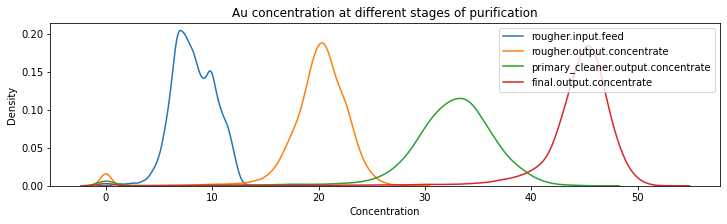

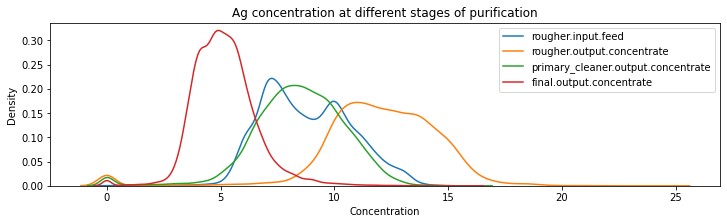

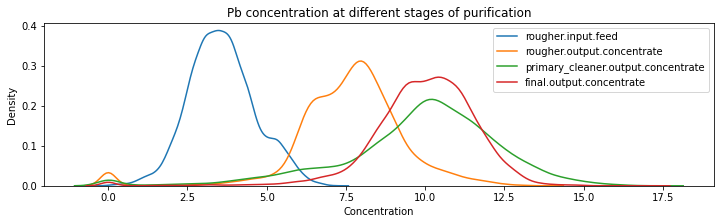

In [29]:
for metal in metals:
    plt.figure(figsize=(12, 3))
    for stage in stages:
        sns.kdeplot(df_full[f'{stage}_{metal}'].dropna(), label=stage)
    plt.title(f'{metal.capitalize()} concentration at different stages of purification')
    plt.xlabel('Concentration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

- Закономерно, концентрация золота(Au) увеличивается по ходу процесса очистки. На финальной стадии концентрация максимальная. Также, имеется малый процент обработок, в ходе которых концентрация золота становится равная 0.
- Концентрация серебра(Ag) после первого этапа возрастает, а затем медленно, на последующих этапах, падает. И, на финальном этапе концентрация становится меньше концентрации в сырье. Также, имеется малый процент обработок, в ходе которых концентрация серебра становится равная 0.
- Концентрация свинца(Pb) после первого этапа резко возрастает, а затем очень медленно увеличивается. Второй этап и финальный практически не отличаются. Предполагаю, что это связано с технологическим процессом. Также, имеется малый процент обработок, в ходе которых концентрация свинца становится равная 0.

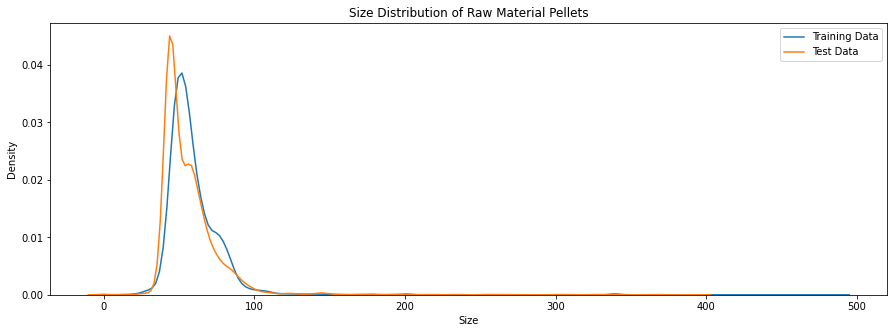

In [30]:
plt.figure(figsize=(15, 5))
sns.kdeplot(df_train['rougher.input.feed_size'].dropna(), label='Training Data')
sns.kdeplot(df_test['rougher.input.feed_size'].dropna(), label='Test Data')
plt.title('Size Distribution of Raw Material Pellets')
plt.xlabel('Size')
plt.ylabel('Density')
plt.legend()
plt.show()

Не значительно, но в тестовом датасете сконцентрировано больше значений с меньшим размером исходного материала. В тренировочном, размер сырьевого материала имеет большое отклонение и медиана среднего размера выше.

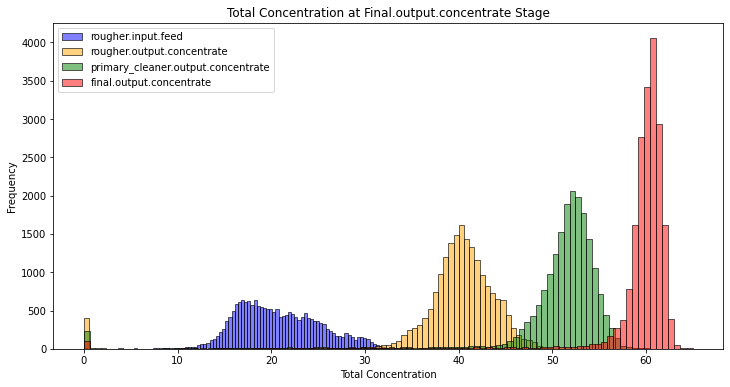

In [31]:
plt.figure(figsize=(12, 6))
col = ['blue', 'orange', 'green', 'red']

for stage, color in zip(stages, col):
    total_concentration = df_full[f'{stage}_au'] + df_full[f'{stage}_ag'] + df_full[f'{stage}_pb']
    sns.histplot(total_concentration.dropna(), bins=100, color=color, alpha=0.5)
    plt.title(f'Total Concentration at {stage.capitalize()} Stage')
    plt.xlabel('Total Concentration')
    plt.ylabel('Frequency')

plt.legend(stages)
plt.show()

На входе, сырой материал имеет большой разброс значений и низкий процент концентрации ценных металлов. По ходу протекания очистки, концентрация увеличивается и разброс уменьшается. Можно говорит о том, что полученные данные указывают на эффективную работу предприятия. После того, как мы убедились в качестве данных и провели предобработку, можно переходить к обучению и тестированию моделей.

Также, можно наблюдать ту самую нулевую концентрацию. Для примера, ниже сделан вывод аналогичного графика, но по выборке `df_train`, в которой мы уже удалили эти выбросы.

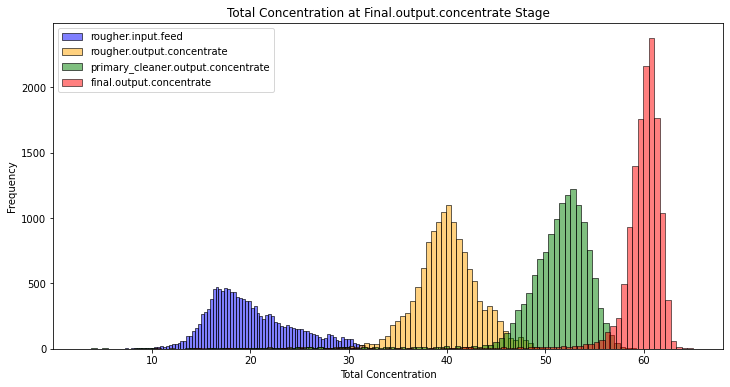

In [32]:
plt.figure(figsize=(12, 6))
col = ['blue', 'orange', 'green', 'red']

for stage, color in zip(stages, col):
    total_concentration = df_train[f'{stage}_au'] + df_train[f'{stage}_ag'] + df_train[f'{stage}_pb']
    sns.histplot(total_concentration.dropna(), bins=100, color=color, alpha=0.5)
    plt.title(f'Total Concentration at {stage.capitalize()} Stage')
    plt.xlabel('Total Concentration')
    plt.ylabel('Frequency')

plt.legend(stages)
plt.show()

## Модель

In [33]:
sMAPE_scorer = make_scorer(sMAPE, greater_is_better=False)

Создаем собственную метрику, на основе функции sMAPE. Относительно нее будет происходить подбор параметров во время обучения.

In [34]:
param_grid = {
    'n_estimators': [210],
    'max_depth': range(22, 25),
    'min_samples_split': [8],
    'min_samples_leaf': [4],
    'max_features': ['auto', 'sqrt', 'log2']
}

Создаем сетку параметров для обучения и подбора наилучших для модели случайного леса.

In [35]:
# %%time
#
# rf = RandomForestRegressor(random_state=random_seed)
# grid_search_rougher = GridSearchCV(rf, param_grid, scoring=sMAPE_scorer, n_jobs=-1, verbose=3, cv=5)
# grid_search_rougher.fit(features_train, target_rougher_train)

Находим наилучшие гиперпараметры для модели случайного леса, исходя из метрики sMAPE

In [36]:
# best_params_rougher = grid_search_rougher.best_params_

best_params_rougher = {'max_depth': 22, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 210}
# cv_result = grid_search_rougher.cv_results_
print(f'Best params (rougher): {best_params_rougher}')

Best params (rougher): {'max_depth': 22, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 210}


Выводим лучшие параметры и записываем их в переменную.

In [37]:
rf_best_rougher = RandomForestRegressor(**best_params_rougher, random_state=random_seed)

rf_best_rougher.fit(features, target_rougher)
prediction_rf = rf_best_rougher.predict(features)

In [38]:
smape_rf_rougher = sMAPE(target_rougher, prediction_rf)
print(f'sMAPE for RandomForestRegressor (rougher): {smape_rf_rougher:.4f}')

sMAPE for RandomForestRegressor (rougher): 1.3687


In [39]:
lr_model_rougher = LinearRegression()

lr_model_rougher.fit(features, target_rougher)

scores = cross_val_score(lr_model_rougher, features, target_rougher, cv=5, scoring=sMAPE_scorer)
sMAPE_rougher = -scores.mean()

prediction_lr = lr_model_rougher.predict(features)

print(f'sMAPE for LinearRegression (rougher): {sMAPE_rougher:.4f}')

sMAPE for LinearRegression (rougher): 7.2240


In [40]:
grb_model_rougher = GradientBoostingRegressor(random_state=random_seed)

grb_model_rougher.fit(features, target_rougher)

scores = cross_val_score(grb_model_rougher, features, target_rougher, cv=5, scoring=sMAPE_scorer)
sMAPE_rougher = -scores.mean()

prediction_grb = grb_model_rougher.predict(features)

print(f'sMAPE for GradientBoostingRegressor (rougher):  {sMAPE_rougher:.4f}')

sMAPE for GradientBoostingRegressor (rougher):  6.1759


In [41]:
# %%time
# rf = RandomForestRegressor(random_state=random_seed)
# grid_search_final = GridSearchCV(rf, param_grid, scoring=sMAPE_scorer, n_jobs=-1, verbose=3, cv=5)
# grid_search_final.fit(features_train, target_final_train)

In [42]:
# best_params_final = grid_search_final.best_params_

best_params_final = {'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 220}
# cv_result = grid_search_final.cv_results_
print(f'Best params (final): {best_params_final}')

Best params (final): {'max_depth': 24, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 220}


In [43]:
rf_best_final = RandomForestRegressor(**best_params_final, random_state=random_seed)

rf_best_final.fit(features, target_final)
prediction_rf = rf_best_final.predict(features)

In [44]:
smape_rf_final = sMAPE(target_final, prediction_rf)
print(f'sMAPE for RandomForestRegressor (final): {smape_rf_final:.2f}')

sMAPE for RandomForestRegressor (final): 3.04


In [45]:
lr_model_final = LinearRegression()

lr_model_final.fit(features, target_rougher)

scores = cross_val_score(lr_model_final, features, target_rougher, cv=5, scoring=sMAPE_scorer)
sMAPE_final = -scores.mean()

prediction_lr_final = lr_model_final.predict(features)

print(f'sMAPE for LinearRegression (final): {sMAPE_final:.2f}')

sMAPE for LinearRegression (final): 7.22


In [46]:
grb_model_final = GradientBoostingRegressor(random_state=random_seed)

grb_model_final.fit(features, target_rougher)

scores = cross_val_score(grb_model_final, features, target_rougher, cv=5, scoring=sMAPE_scorer)
sMAPE_final = -scores.mean()

prediction_grb = grb_model_final.predict(features)

print(f'sMAPE for GradientBoostingRegressor (final):  {sMAPE_final:.2f}')

sMAPE for GradientBoostingRegressor (final):  6.18


In [47]:
print(f'Final sMAPE: {final_sMAPE(smape_rf_rougher, smape_rf_final):.2f}')

Final sMAPE: 2.62


Получаем финальную метрику `final_sMAPE` для лучших моделей. В обоих случаях это случайный лес, но только с разными параметрами. Показатель метрики равен - 6.9629. Теперь, нужно проверить модели на тестовой выборке.

In [48]:
features_test = df_test[features.columns]
full_df_test = df_full.loc[df_full['date'].isin(df_test['date']), df_train.columns]
target_test_rougher = full_df_test['rougher.output.recovery']
target_test_final = full_df_test['final.output.recovery']

In [49]:
features_test = features_test[features.columns]
nona(features_test)
features_test[numeric] = scaler.transform(features_test[numeric])

100%|██████████| 40/40 [00:01<00:00, 33.71it/s]


Производим операции с данными, как над обучающей выборкой, для тестовой выборки.

In [50]:
prediction = rf_best_rougher.predict(features_test)
smape_rf_rougher_test = sMAPE(target_test_rougher, prediction)
print(f'sMAPE (rougher): {smape_rf_rougher_test:.2f}')

sMAPE (rougher): 8.07


In [51]:
prediction_rf = rf_best_final.predict(features_test)
smape_rf_final_test = sMAPE(target_test_final, prediction_rf)
print(f'sMAPE (final): {smape_rf_final_test:.2f}')

sMAPE (final): 9.31


Обучаем модели и получаем показатели ключевой метрики sMAPE.

In [52]:
print(f'Final sMAPE: {final_sMAPE(smape_rf_rougher_test, smape_rf_final_test):.2f}')

Final sMAPE: 9.00


In [53]:
dummy_regr_rougher = DummyRegressor()

dummy_regr_rougher.fit(features, target_rougher)
prediction_dummy_rougher = dummy_regr_rougher.predict(features_test)

sMAPE_dummy_rougher = sMAPE(target_test_rougher, prediction_dummy_rougher)
print('sMAPE rougher(dummy):', sMAPE_dummy_rougher)

sMAPE rougher(dummy): 8.99496551880769


In [54]:
dummy_regr_final = DummyRegressor()

dummy_regr_final.fit(features, target_rougher)
prediction_dummy_final = dummy_regr_final.predict(features_test)

sMAPE_dummy_final= sMAPE(target_test_final, prediction_dummy_final)
print('sMAPE final (dummy):', sMAPE_dummy_final)

sMAPE final (dummy): 22.286673811069303


In [55]:
print(f'Final sMAPE (dummy): {final_sMAPE(sMAPE_dummy_rougher, sMAPE_dummy_final):.2f}')

Final sMAPE (dummy): 18.96


В сравнение с моделей линейной регрессии, DummyRegressor показал результат сильно хуже. Это еще один факт, который дает уверенность в полученной модели.

Note: Для данных моделей не были подобраны оптимальные параметры из-за дедлайнов во время обучения. Поэтому, чтобы модели показали наилучший результат, нужно еще заняться подбором параметров.

## Выводы

В ходе исследования наилучшие результаты показали модели `rf_best_rougher` и `rf_best_final` для предсказания `rougher.output.recovery` и `final.output.recovery`, соответственно. Данные модели, являются моделями случайного леса с подобранными параметрами. Сравнение проводилось между следующими моделями: Линейная регрессия, Градиентный бустинг, Случайный лес. В обоих случаях случайный лес показал наилучший результат. Для `rougher.output.recovery` показатель sMAPE равен - 8.07, а для `final.output.recovery` показатель sMAPE равен - 9.31. По итогу, `final_sMAPE` равен - 9.00. Модели показали не плохой результат. Если учитывать то, что тестовая выборка и обучающая немног отличаются (из анализа), мы закономерно получаем чуть хуже результат. Данную модель можно использовать для предсказания целевых признаков.